# Data preparation 

In [1]:
# Importations


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np



SEED = 77


In [2]:
# Load all the csv data 


meta = pd.read_csv('meta.csv')
taxo = pd.read_csv('taxo.csv')

features_nat = pd.read_csv('features_native.csv.gz')
features_sk = pd.read_csv('features_skimage.csv.gz')

In [3]:
meta.shape

(243610, 14)

In [4]:
meta.columns

Index(['objid', 'projid', 'id', 'status', 'latitude', 'longitude', 'objdate',
       'objtime', 'depth_min', 'depth_max', 'unique_name', 'lineage', 'level1',
       'level2'],
      dtype='object')

## 1. Data Preparation

In [5]:
df = meta.merge(features_nat, left_on='objid', right_on='objid')
df = df.merge(features_sk , left_on='objid', right_on = 'objid')

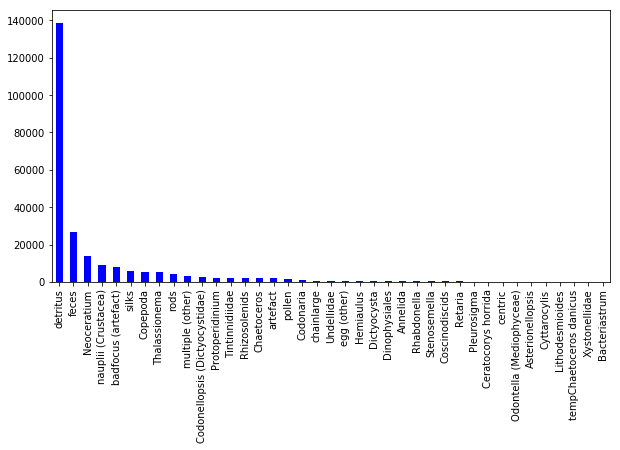

In [6]:
# Plot the repartition of the labels
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

We remove the detritus data that leads to unbalanced dataset

In [7]:
# Remove the unbalanced class to have the same number of labels than the second class
idx_to_drop = meta[meta.level2 == 'detritus'].iloc[:111503,:].index

In [8]:
meta.drop(index = idx_to_drop, inplace = True)

In [9]:
meta.level2.value_counts()

feces                             26936
detritus                          26936
Neoceratium                       14014
nauplii (Crustacea)                9293
badfocus (artefact)                7848
silks                              5629
Copepoda                           5141
Thalassionema                      5117
rods                               4044
multiple (other)                   3261
Codonellopsis (Dictyocystidae)     2888
Protoperidinium                    2256
Tintinnidiidae                     2227
Rhizosolenids                      2160
Chaetoceros                        2105
artefact                           1849
pollen                             1821
Codonaria                           845
chainlarge                          751
Undellidae                          710
egg (other)                         685
Hemiaulus                           670
Dictyocysta                         549
Dinophysiales                       525
Annelida                            481


## Load the images

In [10]:
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


img_files = extract_zip_to_memory("imgs.zip")

# Display an example image 
Image.open(img_files['imgs/32738710.jpg'])

# Load the image as a numpy array:
np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))

# Be aware that the dictionary will occupy roughly 2GB of computer memory!
# To free this memory again, run:
# del img_files

In [11]:
# Creation of the array with all the images
X = []

for index, img in enumerate(img_files) :
    
     X.append(   np.array(Image.open(img_files[img]))      )


    


In [12]:
def convert_image(array) :
    # Plot an image from a numpy array
    return Image.fromarray(array)



In [13]:
indexes_nan_level2 = meta.level2[meta.level2.isnull()].index

meta.drop(indexes_nan_level2 , axis = 0 , inplace = True)

In [14]:
# Convert the label into classes
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
meta.level2 = le.fit(meta.level2).transform(meta.level2)







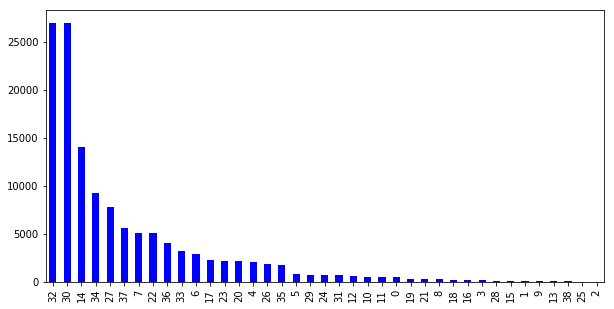

In [15]:
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

In [84]:
X_resized = []
y_img = []

for img in img_files : 
    value = int(img[5:].split('.')[0])
    # The position of the image in the database
    index_img = np.where(meta.objid == value)

    if index_img[0] :
        # Check if the label is not NaN
        
        lvl2 = meta.level2.iloc[index_img[0][0]]
        
        # Loop over the dictionnary of data augmentation 
                   
        x = Image.open(img_files[img]).resize((32,32), Image.ANTIALIAS) 
        X_resized.append( (1/255) * np.array(x).flatten()  )
        y_img.append(lvl2)
    
       

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [85]:
label_augm = pd.DataFrame({'level2' : y_img})


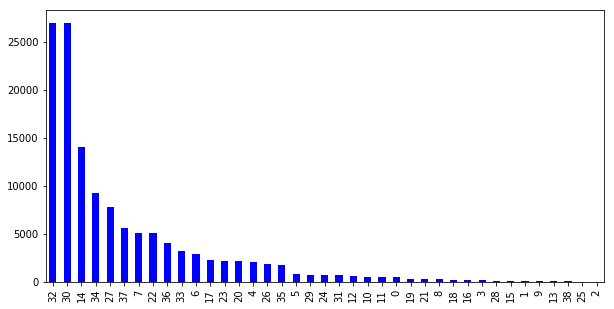

In [86]:
# Data augmented 
label_augm.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

In [87]:
def hot_encode(y) : 
    
    new_y = np.zeros((len(y),39))
    
    for index, y in enumerate(y) : 
        
        new_y[index,y] = 1
        
    return new_y

In [88]:
new_y = hot_encode(y_img)

In [89]:
new_y.shape

(131103, 39)

In [90]:
X_resized = np.array(X_resized)

# Split into training set and testing set

In [91]:
idx_test = np.random.choice(np.arange(X_resized.shape[0]) , int(X_resized.shape[0] * 0.1))

In [92]:
idx_train = np.ones( X_resized.shape[0] , bool)
idx_train[idx_test] = False


In [93]:
X_resized.shape

(131103, 1024)

In [94]:
X_resized[idx_test].shape

(13110, 1024)

In [95]:
X_train, X_test, y_train, y_test = X_resized[idx_train] , X_resized[idx_test] , new_y[idx_train,:],new_y[idx_test,:]

### Validation set

In [96]:
idx_val = np.random.choice(np.arange(X_train.shape[0]) , int(X_train.shape[0] * 0.1))

In [97]:
idx_train = np.ones( X_train.shape[0] , bool)
idx_train[idx_val] = False


In [98]:
X_train, X_val, y_train, y_val = X_train[idx_train] , X_train[idx_val,:] , y_train[idx_train,:],y_train[idx_val,:]

In [99]:
print('X Train : {}, y train : {} \n X Val : {} y Val : {} \nX test : {} y test : {}'\
      .format(X_train.shape,y_train.shape,X_val.shape,y_val.shape, X_test.shape, y_test.shape))

X Train : (107277, 1024), y train : (107277, 39) 
 X Val : (11862, 1024) y Val : (11862, 39) 
X test : (13110, 1024) y test : (13110, 39)


In [32]:

def f1_score(y_true, y_pred):

    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


    
    
    

## Simple Neural Network

In [33]:
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D


Using TensorFlow backend.


In [85]:
# Creation of the model 

def simple_neural_network(input_shape) : 
    
    X_input = Input(input_shape)
    
    X =Dense(200, activation = 'relu')(X_input)
    X = Dense(39, activation='softmax', name ='fc')(X)
    
    
    model = Model(inputs = X_input , outputs=X , name = 'simpleNn')
    
    return model
        

In [86]:
simpleNN = simple_neural_network(X_train.shape[1:])

In [87]:

simpleNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics = [f1_score])

In [97]:
simpleNN.fit(x=X_train, y = y_train, epochs = 100 , batch_size = 500)

Epoch 1/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4234 - f1_score: 0.1728
Epoch 2/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4177 - f1_score: 0.1751
Epoch 3/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4138 - f1_score: 0.1762
Epoch 4/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4097 - f1_score: 0.1788
Epoch 5/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4058 - f1_score: 0.1801
Epoch 6/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.4030 - f1_score: 0.1808
Epoch 7/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.3989 - f1_score: 0.1819
Epoch 8/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.3932 - f1_score: 0.1834
Epoch 9/100
107328/107328 [==============================] - 2s 17us/step - loss: 1.3926 - f1_score: 0.1868
Epoch 10/100
107328/107328 [

In [98]:
results = simpleNN.evaluate(X_val, y_val, batch_size=128)


11861/11861 [==============================] - 0s 25us/step


In [101]:
print('Loss on the validation set : {}\nF1 score for validation set : {}'.format(*results))

Loss on the validation set : 1.3303099788769974
F1 score for validation set : 0.17995169758796692


## Custom Neural Network


In [202]:
def custom_model(input_shape) : 
    
    
    X_input = Input(input_shape)
#     X = Reshape((-1,28,28), input_shape=input_shape)(X_input)
    
    
    X = ZeroPadding2D((2,2))(X_input)
    X = Conv2D(32, (2,2), strides = (1,1), name='conv0', input_shape =(28,28,1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2,2), name = 'maxpool')(X)
    X = Flatten()(X)

    X = Dense( 39, activation='sigmoid', name ='fc')(X)
    
    
    model = Model(inputs = X_input , outputs=X , name = 'CustomModel')
    
    return model
    
    

In [37]:
x_train = X_train.reshape(-1,28,28,1)
x_val = X_val.reshape(-1,28,28,1)
x_test = X_test.reshape(-1,28,28,1)



In [204]:
customNN = custom_model(x_train.shape[1:])

In [205]:
customNN.compile(optimizer='adam',  loss='categorical_crossentropy', metrics = [f1_score])

In [208]:
customNN.fit(x=x_train, y = y_train, epochs = 10, batch_size = 500)

Epoch 1/10
107328/107328 [==============================] - 40s 371us/step - loss: 0.8077 - f1_score: 0.0833
Epoch 2/10
107328/107328 [==============================] - 40s 373us/step - loss: 0.8056 - f1_score: 0.0836
Epoch 3/10
107328/107328 [==============================] - 40s 371us/step - loss: 0.8015 - f1_score: 0.0834
Epoch 4/10
107328/107328 [==============================] - 40s 372us/step - loss: 0.7901 - f1_score: 0.0833
Epoch 5/10
107328/107328 [==============================] - 40s 373us/step - loss: 0.7842 - f1_score: 0.0824
Epoch 6/10
107328/107328 [==============================] - 40s 373us/step - loss: 0.7759 - f1_score: 0.0820
Epoch 7/10
107328/107328 [==============================] - 40s 372us/step - loss: 0.7762 - f1_score: 0.0821
Epoch 8/10
107328/107328 [==============================] - 40s 370us/step - loss: 0.7673 - f1_score: 0.0824
Epoch 9/10
107328/107328 [==============================] - 40s 373us/step - loss: 0.7592 - f1_score: 0.0846
Epoch 10/10
107328/

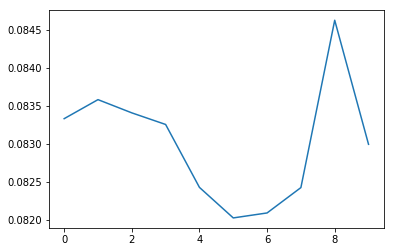

In [215]:
plt.plot(customNN.history.history['f1_score'])

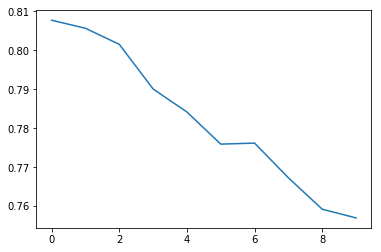

In [217]:
plt.plot(customNN.history.history['loss'])

In [218]:
results_custom = customNN.evaluate(x_val, y_val, batch_size=128)


11861/11861 [==============================] - 2s 144us/step


In [220]:
print('Loss on the validation set : {}\nF1 score for validation set : {}'.format(*results_custom))

Loss on the validation set : 3.3138737857829215
F1 score for validation set : 0.03775671869516373


## Transfer Learning 

VGG16 is a convolutional neural network model that achieved 92.7% on top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 

We decided to use this architecture for our problem. 

In [40]:
from keras.applications.vgg16 import VGG16

#### Features extraction

In [71]:
X_train.reshape((-1,28,28)).shape

(107342, 28, 28)

In [101]:
X_train_tf = np.stack([X_train.reshape(-1,32,32)]*3, axis=-1)
X_val_tf = np.stack([X_val.reshape(-1,32,32)]*3, axis=-1)
X_test_tf = np.stack([X_test.reshape(-1,32,32)]*3, axis=-1)


In [104]:
def transfer_model(input_shape) : 
    
    
    
    model = VGG16(include_top=False, input_shape = (32,32,3))
    
    X = Flatten()(model.outputs)
    X = Dense(1024, activation='relu')(X)
    output = Dense(39,activation='softmax')(X)
    model = Model(inputs = model.inputs, outputs = output)
    
    return model
    
    
    

In [105]:
t_model = transfer_model(X_train_tf.shape[1:])

In [106]:
t_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

#### Let s freeze the weights of the VGG model

In [108]:
for layer in t_model.layers : 
    layer.trainable = False

In [ ]:
t_model.get_layer('').trainable = True

In [ ]:
t_model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics = [f1_score])